In [105]:
from pathlib import Path as pt
import umap
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from typing import List
import warnings
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from typing import Dict, Tuple

from rdkit import Chem
from sklearn.cluster import DBSCAN

warnings.filterwarnings('ignore')
tqdm.pandas()

In [96]:
from load_data import embedded_vectors_dir, names, titles, plots_dir, property_units, property_names
names, plots_dir

(['tmpC_topelements',
  'tbp_topelements',
  'vp_kPa_25C_topelements',
  'Pc_MPa',
  'Tc_K'],
 PosixPath('/Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/ML-properties/plots'))

In [84]:
class ChemicalClusterAnalyzer:
    """Analyzes chemical structure clusters and their functional groups."""

    def __init__(self):
        # Define common functional groups and their SMARTS patterns
        self.functional_groups = {
            "Alcohol": "[OH]",
            "Carboxylic Acid": "[CX3](=O)[OX2H1]",
            "Ester": "[#6][CX3](=O)[OX2H0][#6]",
            "Ether": "[OD2]([#6])[#6]",
            "Aldehyde": "[CX3H1](=O)[#6]",
            "Ketone": "[#6][CX3](=O)[#6]",
            "Amine": "[NX3;H2,H1;!$(NC=O)]",
            "Amide": "[NX3][CX3](=[OX1])[#6]",
            "Aromatic": "a1aaaaa1",
            "Alkene": "[CX3]=[CX3]",
            "Alkyne": "[CX2]#[CX2]",
            "Nitrile": "[NX1]#[CX2]",
            "Nitro": "[NX3](=O)=O",
            "Sulfonic Acid": "[SX4](=[OX1])(=[OX1])[OX2H]",
            "Phosphate": "[PX4](=[OX1])([OX2H])([OX2H])[OX2H]",
            "Halogen": "[F,Cl,Br,I]",
        }

    def identify_functional_groups(self, smiles: str) -> Dict[str, int]:
        """
        Identifies functional groups in a molecule.

        Args:
            smiles: SMILES string of the molecule

        Returns:
            Dictionary of functional group counts
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return {}

            groups = {}
            for name, smarts in self.functional_groups.items():
                pattern = Chem.MolFromSmarts(smarts)
                if pattern is not None:
                    matches = mol.GetSubstructMatches(pattern)
                    if matches:
                        groups[name] = len(matches)
            return groups
        except Exception:
            return {}

    def analyze_cluster_chemistry(
        self,
        reduced_embeddings: np.ndarray,
        smiles_list: List[str],
        eps: float = 0.5,
        min_samples: int = 5,
    ) -> Tuple[np.ndarray, Dict]:
        """
        Performs clustering and analyzes chemical features of each cluster.

        Args:
            reduced_embeddings: UMAP-reduced embeddings
            smiles_list: List of SMILES strings
            eps: DBSCAN epsilon parameter
            min_samples: DBSCAN minimum samples parameter

        Returns:
            Cluster labels and cluster analysis results
        """
        # Perform DBSCAN clustering
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(reduced_embeddings)
        labels = clustering.labels_

        # Analyze each cluster
        cluster_analysis = {}
        for cluster_id in tqdm(set(labels)):
            if cluster_id == -1:  # Skip noise points
                continue

            # Get SMILES strings for this cluster
            cluster_mask = labels == cluster_id
            cluster_smiles = np.array(smiles_list)[cluster_mask]

            # Analyze functional groups
            all_groups = []
            for smiles in cluster_smiles:
                groups = self.identify_functional_groups(smiles)
                all_groups.extend(groups.keys())

            # Calculate group frequencies
            group_freq = Counter(all_groups)
            total_mols = len(cluster_smiles)
            group_freq = {k: v / total_mols for k, v in group_freq.items()}

            # Store analysis results
            cluster_analysis[cluster_id] = {
                "size": sum(cluster_mask),
                "functional_groups": group_freq,
                "center": reduced_embeddings[cluster_mask].mean(axis=0),
            }

        return labels, cluster_analysis



In [121]:
def get_umap_df(
    ind: int,
    n_neighbors = 15,
    min_dist = 0.1,
    random_state = 42,
    dbscan_eps = 0.7,
    dbscan_min_samples = 15,
    perplexity = 3,
    mode: str = 'umap'
):
    
    n_components = 2
    
    df = pd.read_parquet(embedded_vectors_dir[ind] / 'processed_mol2vec_embeddings' / 'processed_df.parquet')
    label_issues_df = pd.read_parquet(embedded_vectors_dir[ind] / 'processed_mol2vec_embeddings' / 'label_issues_xgboost.parquet')
    cleaned_df = df[~label_issues_df["is_label_issue"]]
    print(f'Original data: {df.shape}, Cleaned data: {cleaned_df.shape}')

    smiles_list = cleaned_df['SMILES'].to_list()
    print(f'SMILES list: {len(smiles_list)}')

    X = cleaned_df.iloc[:, 2:].to_numpy()
    y = cleaned_df["y"].to_numpy()
    print(f'X: {X.shape}, y: {y.shape}')

    # Scale embeddings
    print("Scaling embeddings...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform UMAP
    if mode == 'umap':
        print("Performing UMAP...")
        reducer = umap.UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=n_components,
            n_jobs=-1,
            random_state=random_state
        )

        reduced_embeddings = reducer.fit_transform(X_scaled)
        print(f'UMAP done: {reduced_embeddings.shape}')
    elif mode == 'tsne':    
        reducer = TSNE(n_components=n_components, learning_rate='auto', init='random', perplexity=perplexity)
        reduced_embeddings = reducer.fit_transform(X_scaled)
        print(f'TSNE done: {reduced_embeddings.shape}')

    print("Analyzing clusters...")
    analyzer = ChemicalClusterAnalyzer()
    labels, cluster_analysis = analyzer.analyze_cluster_chemistry(
        reduced_embeddings,
        smiles_list,
        eps=dbscan_eps,
        min_samples=dbscan_min_samples,
    )
    print(f'Labels: {len(labels)}')

    umap_df = pd.DataFrame(
        {
            "INDEX": cleaned_df.index,
            "UMAP1": reduced_embeddings[:, 0],
            "UMAP2": reduced_embeddings[:, 1],
            "Cluster": labels,
            "SMILES": smiles_list,
            "y": y,
        }
    )
    
    return umap_df, cluster_analysis


In [67]:
def annotate_fig(umap_df: pd.DataFrame, ax: plt.Axes):
    # Define distinct colors for clusters
    # cluster_colors = plt.cm.tab20(np.linspace(0, 1, len(umap_df['Cluster'].unique())))
    
    # Add cluster circles and labels
    for idx, cluster_id in enumerate(sorted(umap_df['Cluster'].unique())):
        if cluster_id == -1:  # Skip noise points
            continue
            
        # Get points for this cluster
        cluster_points = umap_df[umap_df['Cluster'] == cluster_id]
        
        # Calculate cluster center
        center_x = cluster_points['UMAP1'].mean()
        center_y = cluster_points['UMAP2'].mean()
        
        # Calculate cluster radius
        std_x = cluster_points['UMAP2'].std() * 2
        std_y = cluster_points['UMAP2'].std() * 2
        radius = max(std_x, std_y)
        
        # Get color for this cluster
        # cluster_color = cluster_colors[idx]
        cluster_color = 'black'
        # Draw circle around cluster
        circle = plt.Circle(
            (center_x, center_y),
            radius,
            fill=False,
            linestyle='-',
            color=cluster_color,
            alpha=0.5,
            # linewidth=2
        )
        ax.add_patch(circle)
        
        # Add just the cluster ID at the circle's boundary
        # Calculate position on the circle's circumference (top of circle)
        label_x = center_x
        label_y = center_y + radius
        
        # Add cluster label with white background for better visibility
        ax.text(label_x, label_y, str(cluster_id),
                horizontalalignment='center',
                verticalalignment='bottom',
                color=cluster_color,
                fontweight='bold',
                fontsize=12,
                # bbox=dict(facecolor='white', 
                #          edgecolor=cluster_color,
                #          alpha=0.9,
                #          pad=0.5,
                #          boxstyle='round')
                )
    return ax

def static_fig(umap_df: pd.DataFrame, title_name: str, short_title_name: str):
    plt.clf()
    fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

    # Create the scatter plot using seaborn
    scatter = sns.scatterplot(
        data=umap_df,
        x="UMAP1",
        y="UMAP2",
        hue="y",
        palette="viridis",
        ax=ax,
        s=50,
        alpha=0.6,
    )

    # Remove the automatic legend
    scatter.legend_.remove()

    # Create and customize the colorbar
    norm = plt.Normalize(umap_df["y"].min(), umap_df["y"].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    colorbar = fig.colorbar(sm, ax=ax)
    colorbar.set_label(title_name, fontsize=12)

    ax.set_xlabel("UMAP1", fontsize=12)
    ax.set_ylabel("UMAP2", fontsize=12)
    ax.set_title(short_title_name, fontsize=16)
    
    plt.tight_layout()
    # plt.show()
    return fig, ax

Original data: (7476, 302), Cleaned data: (6167, 302)
SMILES list: 6167
X: (6167, 300), y: (6167,)
Scaling embeddings...
Performing UMAP...
UMAP done: (6167, 2)
Analyzing clusters...


100%|██████████| 8/8 [00:00<00:00,  8.17it/s]

Labels: 6167


<Figure size 640x480 with 0 Axes>

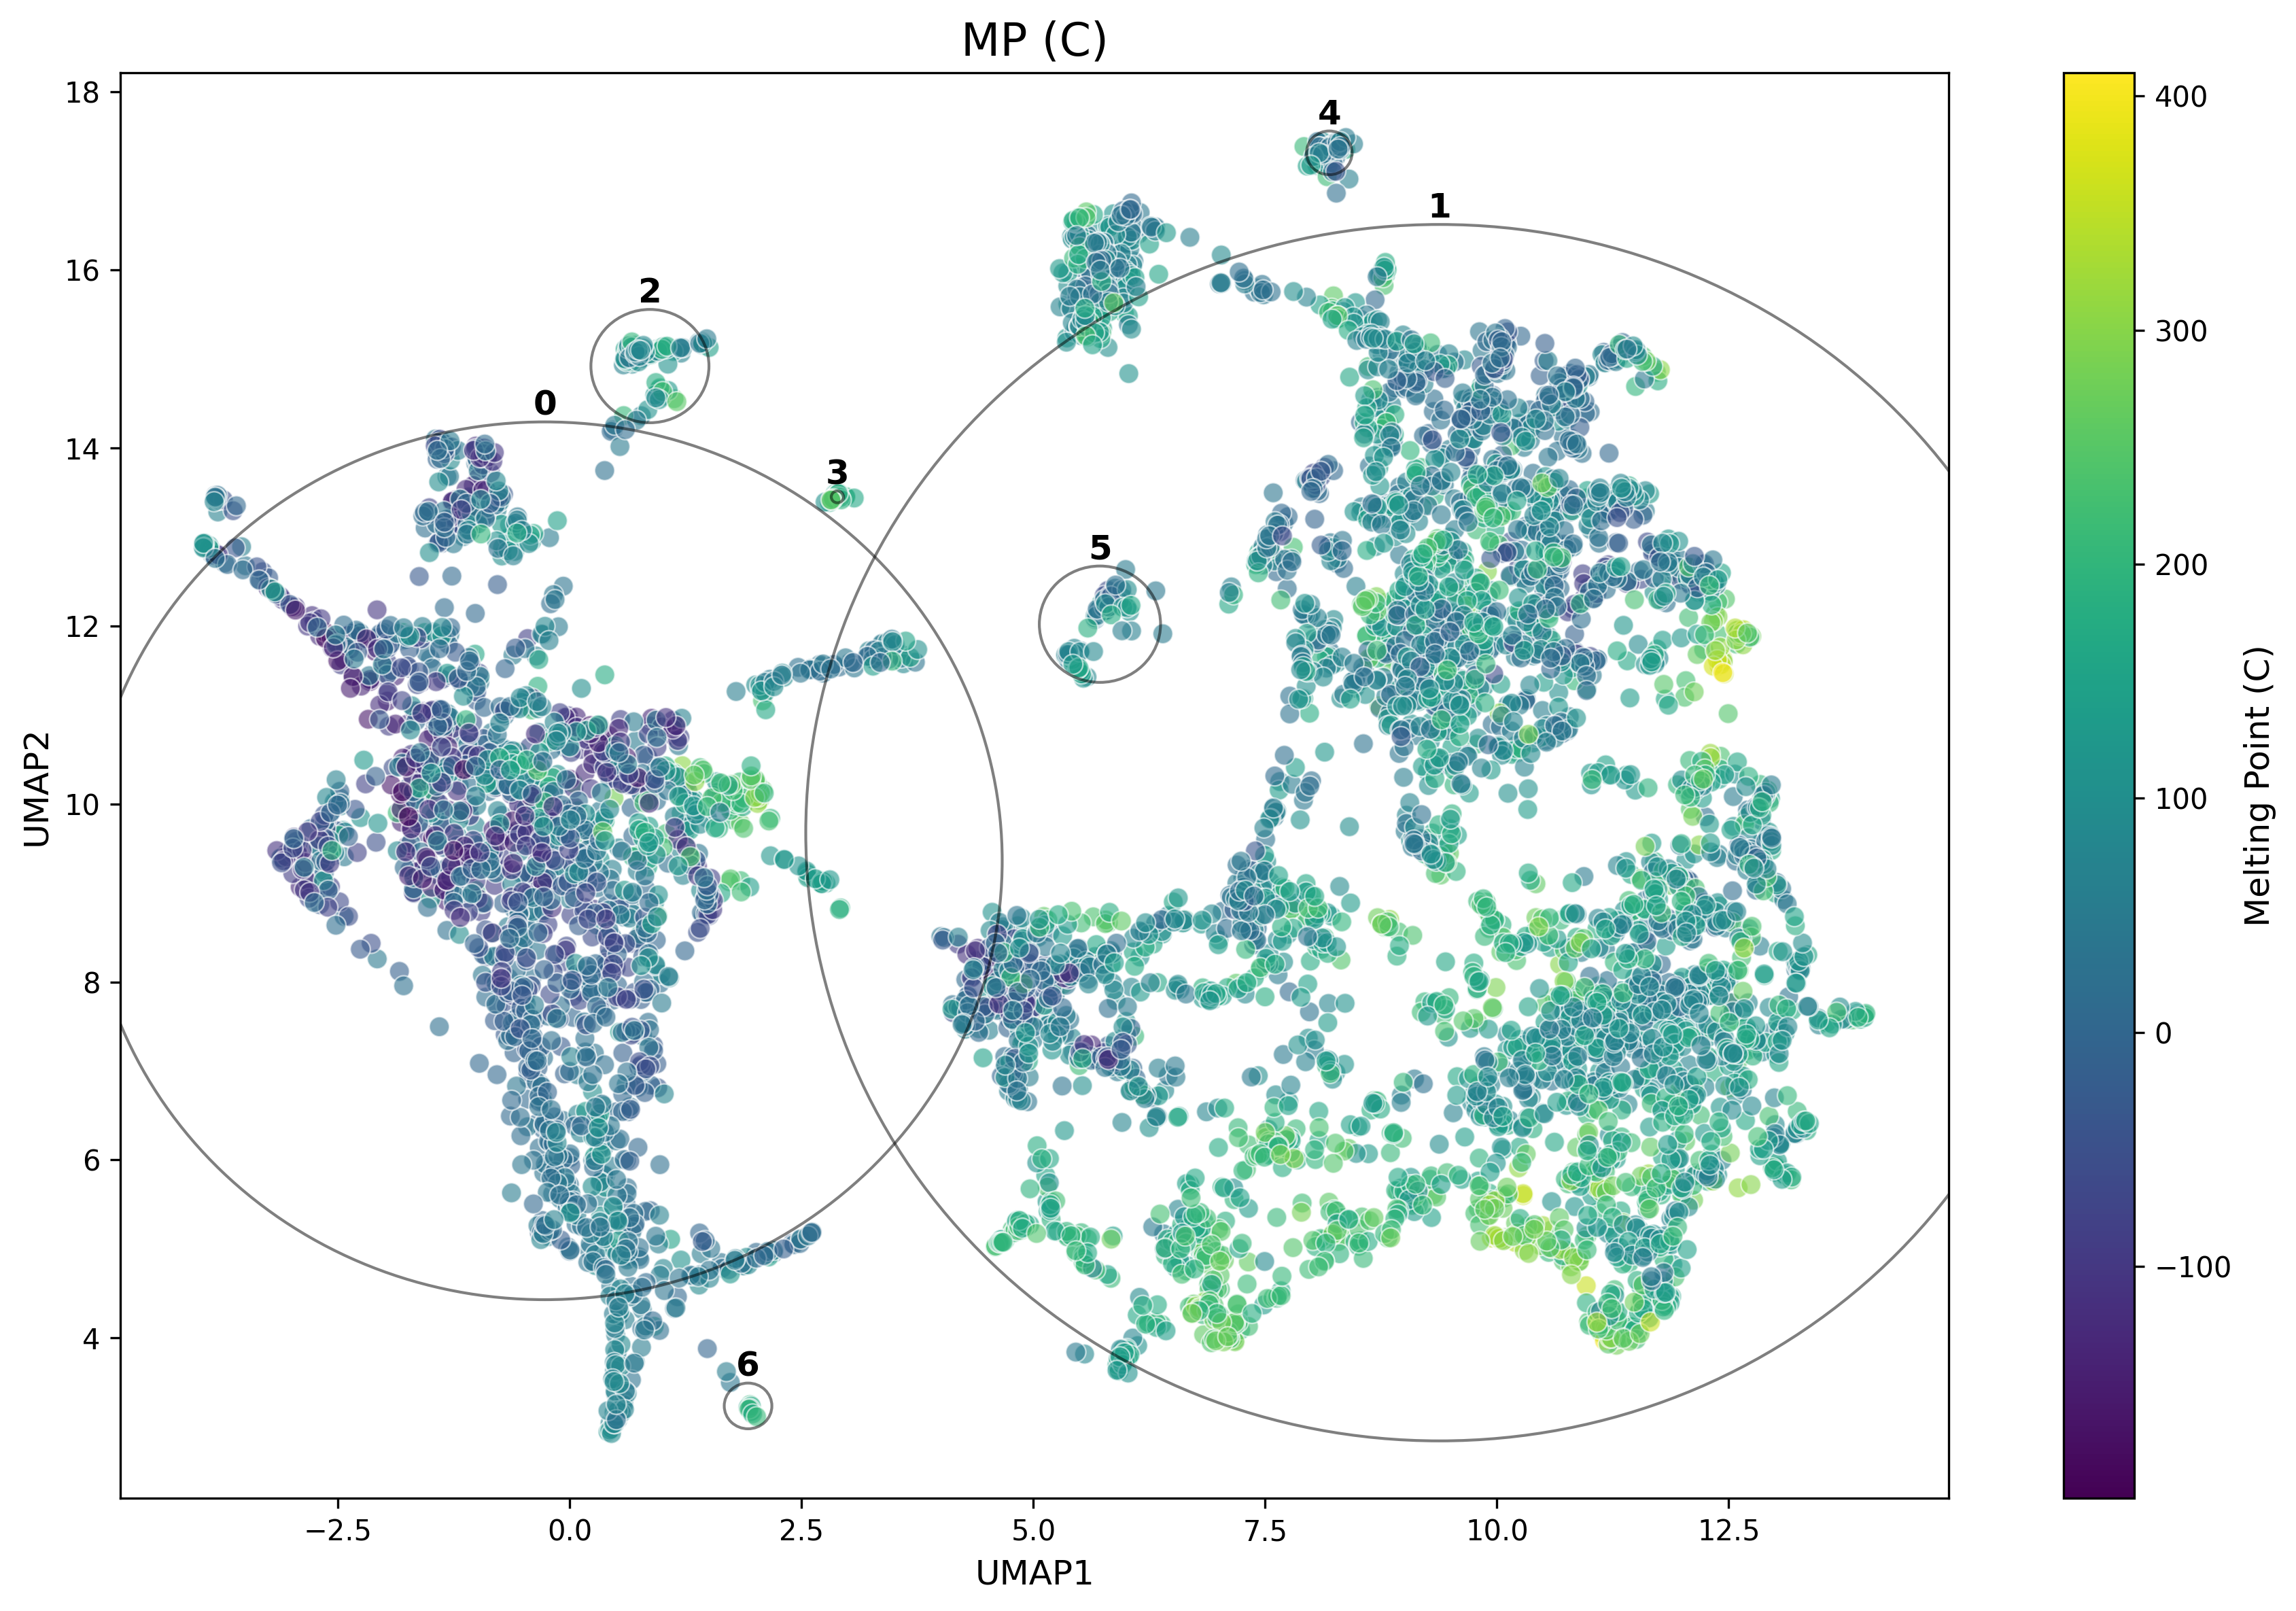

In [157]:
ind = 0
# print(titles[ind])
n_neighbors = 25
min_dist = 0.3
random_state = 42
dbscan_eps = 0.7
dbscan_min_samples = 15
perplexity = 60
mode = 'umap'
# mode = 'tsne'

umap_df, cluster_analysis = get_umap_df(
    ind, 
    n_neighbors, 
    min_dist, 
    random_state, 
    dbscan_eps, 
    dbscan_min_samples, 
    perplexity, 
    mode=mode
)

# umap_df = pd.read_parquet(
#     embedded_vectors_dir[ind] / f'processed_mol2vec_embeddings/umap/cleaned_label_issues_xgboost/[umap_df]_{names[ind]}_scaled_random_state_42_umap_25_0.3_2_cluster_eps_0.7_min_samples_15.parquet'
# )

title_name = f'{property_names[ind]} ({property_units[ind]})'
short_title_name = f'{titles[ind]} ({property_units[ind]})'
fig, ax = static_fig(umap_df, title_name, short_title_name)
ax = annotate_fig(umap_df, ax)
# fig.savefig(plots_dir / f'{names[ind]}_umap.png')
plt.show()

In [130]:
cluster_analysis[0]['functional_groups']

{'Aromatic': 0.05403959336543606,
 'Amide': 0.04922418405564473,
 'Aldehyde': 0.021936864633493848,
 'Alcohol': 0.31086142322097376,
 'Carboxylic Acid': 0.164258962011771,
 'Ester': 0.1332263242375602,
 'Ether': 0.18940609951845908,
 'Ketone': 0.04868913857677903,
 'Amine': 0.10700909577314072,
 'Nitrile': 0.038523274478330656,
 'Halogen': 0.23542001070090957,
 'Alkyne': 0.0299625468164794,
 'Alkene': 0.12894596040663456,
 'Sulfonic Acid': 0.005350454788657036}

In [69]:
for ind in range(0, len(embedded_vectors_dir)):
    umap_df = pd.read_parquet(
        embedded_vectors_dir[ind] / f'processed_mol2vec_embeddings/umap/cleaned_label_issues_xgboost/[umap_df]_{names[ind]}_scaled_random_state_42_umap_25_0.3_2_cluster_eps_0.7_min_samples_15.parquet'
    )
    # print(umap_df['Cluster'].unique(), umap_df['Cluster'].value_counts())
    # display(umap_df)

    title_name = f'{property_names[ind]} ({property_units[ind]})'
    short_title_name = f'{titles[ind]} ({property_units[ind]})'
    fig, ax = static_fig(umap_df, title_name, short_title_name)
    ax = annotate_fig(umap_df, ax)
    fig.savefig(plots_dir / f'{names[ind]}_umap.png')
    # plt.show()
    plt.close(fig)
    print(f'{names[ind]} done')

tmpC_topelements done
tbp_topelements done
vp_kPa_25C_topelements done
Pc_MPa done
Tc_K done


<Figure size 640x480 with 0 Axes>

In [134]:
umap_df

INDEX      UMAP1     UMAP2  Cluster           SMILES     y
0        1  11.183607  9.420219        0          CC(=O)O  5.79
1        2  11.375243  8.442579        0    CC(=O)OC(C)=O  4.00
2        3  10.972686  9.095401        0          CC(C)=O  4.70
3        4  10.234968  9.764903        0             CC#N  4.88
4        5   6.787386  4.290699        1   CC(=O)c1ccccc1  4.01
..     ...        ...       ...      ...              ...   ...
748    771   6.086975  4.449309        1    Cc1cccc(O)c1C  4.10
749    772   5.837339  4.482044        1  Cc1ccc(O)c(C)c1  3.50
750    773   5.897774  4.316554        1  Cc1ccc(C)c(O)c1  3.90
751    774   6.079676  4.310705        1    Cc1cccc(C)c1O  3.80
752    776   5.798316  4.359482        1  Cc1cc(C)cc(O)c1  3.80

[753 rows x 6 columns]

In [ ]:
def cluster_figures(umap_df: pd.DataFrame, num_molecules: int = 5):
    
    cluster_ids = sorted(umap_df["Cluster"].unique())
    n_clusters = len([i for i in cluster_ids if i != -1])

    # Create figure
    fig, axes = plt.subplots(num_molecules, n_clusters, figsize=(12, 5), dpi=300)

    for cluster_id in cluster_ids:
        if cluster_id == -1:
            continue
        
        smiles_list = umap_df[umap_df["Cluster"] == cluster_id]["SMILES"].tolist()
        mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list[:num_molecules]]
        
        for img_idx, mol in enumerate(mols):
            # Load image
            try:
                # Adjust this path according to your image storage structure
                
                img = Chem.Draw.MolToImage(mol, size=(500, 200))
                # Convert PIL image to numpy array for matplotlib
                img_array = np.array(img)
                
                # Display image
                axes[img_idx, cluster_id].imshow(img_array)
                axes[img_idx, cluster_id].axis('off')  # Turn off axes
                
                # Add column labels (cluster numbers) at the top
                if img_idx == 0:
                    axes[img_idx, cluster_id].set_title(f'Cluster {cluster_id}')
                    
            except Exception as e:
                print(f"Error loading image for cluster {cluster_id}, image {img_idx}: {e}")

    # Adjust layout
    plt.tight_layout()

    # Save the figure
    # plt.savefig('cluster_grid.pdf', bbox_inches='tight', dpi=300)
    # plt.savefig('cluster_grid.png', bbox_inches='tight', dpi=300)
    # plt.close()
    
    plt.show()
    
    return fig, axes

fig, axes = cluster_figures(umap_df, num_molecules=5)

fig.savefig('cluster_grid.png', bbox_inches='tight', dpi=300)
fig.savefig('cluster_grid.pdf', bbox_inches='tight', dpi=300)

plt.show()
plt.close(fig)


Cluster 0 Analysis:

Analyzing Nitro group...

Nitro group frequency:
SMILES
0    528

Analyzing Cyano group...

Cyano group frequency:
SMILES
0    519
1      8
2      1

Analyzing Halogen group...

Halogen group frequency:
SMILES
0     387
6      20
3      17
4      16
1      16
5      13
8      11
7      10
2       9
14      6
9       6
10      5
12      3
11      2
15      1
22      1
16      1
13      1
20      1
18      1
27      1

Analyzing Alcohol group...

Alcohol group frequency:
SMILES
0    430
1     78
2     20


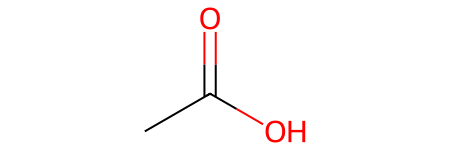

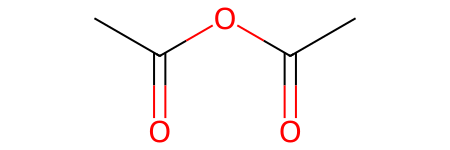

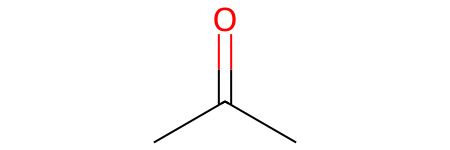

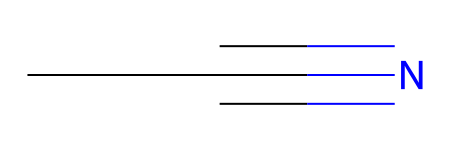

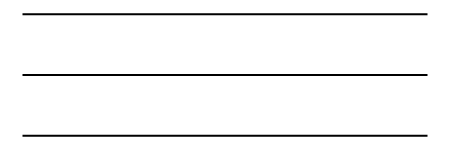


Cluster 1 Analysis:

Analyzing Nitro group...

Nitro group frequency:
SMILES
0    149

Analyzing Cyano group...

Cyano group frequency:
SMILES
0    148
1      1

Analyzing Halogen group...

Halogen group frequency:
SMILES
0     109
2      15
3       7
4       6
1       5
6       3
8       2
10      1
5       1

Analyzing Alcohol group...

Alcohol group frequency:
SMILES
0    126
1     23


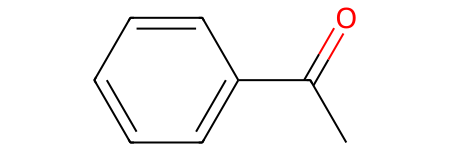

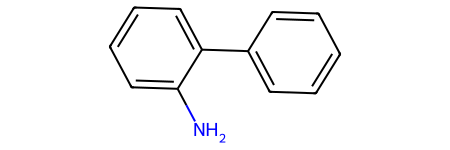

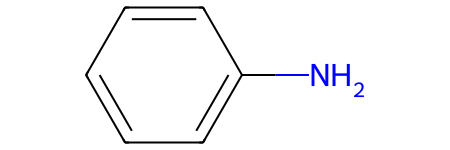

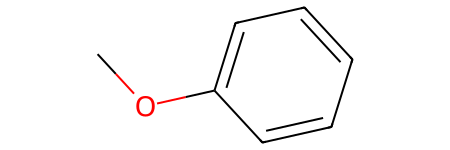

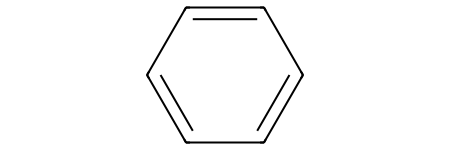


Cluster 2 Analysis:

Analyzing Nitro group...

Nitro group frequency:
SMILES
0    34

Analyzing Cyano group...

Cyano group frequency:
SMILES
0    34

Analyzing Halogen group...

Halogen group frequency:
SMILES
0    34

Analyzing Alcohol group...

Alcohol group frequency:
SMILES
0    31
1     3


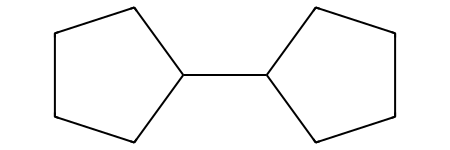

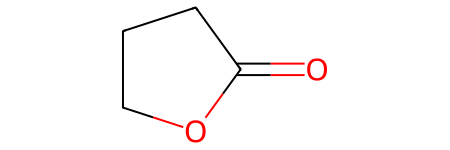

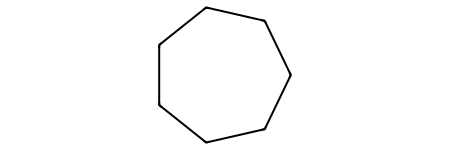

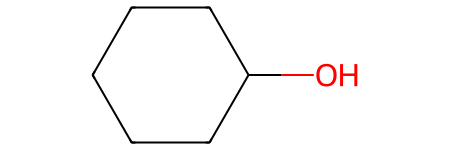

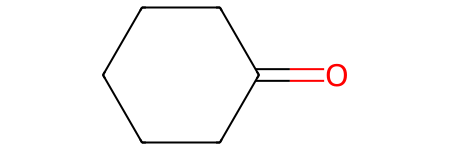


Cluster 3 Analysis:

Analyzing Nitro group...

Nitro group frequency:
SMILES
0    40

Analyzing Cyano group...

Cyano group frequency:
SMILES
0    40

Analyzing Halogen group...

Halogen group frequency:
SMILES
0    38
1     2

Analyzing Alcohol group...

Alcohol group frequency:
SMILES
0    35
1     5


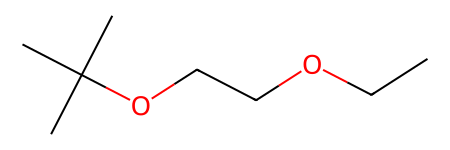

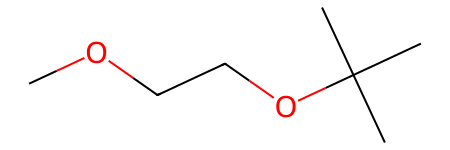

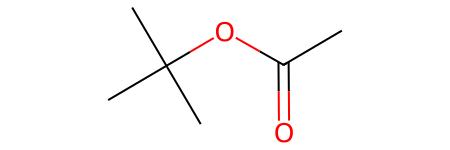

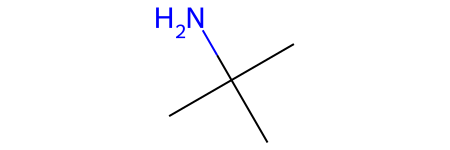

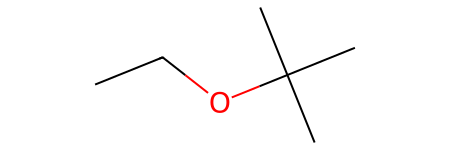

In [146]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem.Draw.rdMolDraw2D import PrepareMolForDrawing

# Create a dictionary to store the results
cluster_analysis: dict[int, pd.DataFrame] = {}

for cluster_id in umap_df["Cluster"].unique():
    if cluster_id == -1:
        continue
    # Get the SMILES strings for the current cluster
    smiles_list = umap_df[umap_df["Cluster"] == cluster_id]["SMILES"].tolist()

    # Create a list to store the analysis results for each molecule in the cluster
    mols_analysis = []

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Invalid SMILES string: {smiles}")
            continue

        # Calculate molecular descriptors
        mol_analysis = {
            "SMILES": smiles,
            "MolWt": Descriptors.MolWt(mol),
            "NumHAcceptors": rdMolDescriptors.CalcNumHBA(mol),
            "NumHDonors": rdMolDescriptors.CalcNumHBD(mol),
            "NumRotatableBonds": rdMolDescriptors.CalcNumRotatableBonds(mol),
            "NumAromaticRings": rdMolDescriptors.CalcNumAromaticRings(mol),
            # Add more descriptors as needed
        }
        mols_analysis.append(mol_analysis)

    cluster_analysis[cluster_id] = pd.DataFrame(mols_analysis)

# Analyze structural and functional group diversity within each cluster
for cluster_id, df_analysis in cluster_analysis.items():
    print(f"\nCluster {cluster_id} Analysis:")

    # Print summary statistics for the calculated descriptors
    # print(df_analysis.describe())

    # Analyze functional group frequencies (example)
    # You can expand this to include more functional groups
    functional_groups = {
        "Nitro": Chem.MolFromSmarts("[NX3](=O)=O"),
        "Cyano": Chem.MolFromSmarts("C#N"),
        "Halogen": Chem.MolFromSmarts("[F,Cl,Br,I]"),
        "Alcohol": Chem.MolFromSmarts("[OH]"),
    }

    for group_name, group_smarts in functional_groups.items():
        print(f"\nAnalyzing {group_name} group...")
        group_count = df_analysis["SMILES"].apply(
            lambda x: len(Chem.MolFromSmiles(x).GetSubstructMatches(group_smarts))
        )
        # display(group_count)
        print(
            f"\n{group_name} group frequency:"
            f"\n{group_count.value_counts().to_string()}"
        )

    # Visualize structures in the cluster (example)
    # This will display the first 5 molecules in the cluster
    for smiles in df_analysis["SMILES"].head():
        mol = Chem.MolFromSmiles(smiles)
        display(PrepareMolForDrawing(mol))
    

[-1, 0, 1, 2, 3, 4, 5, 6]


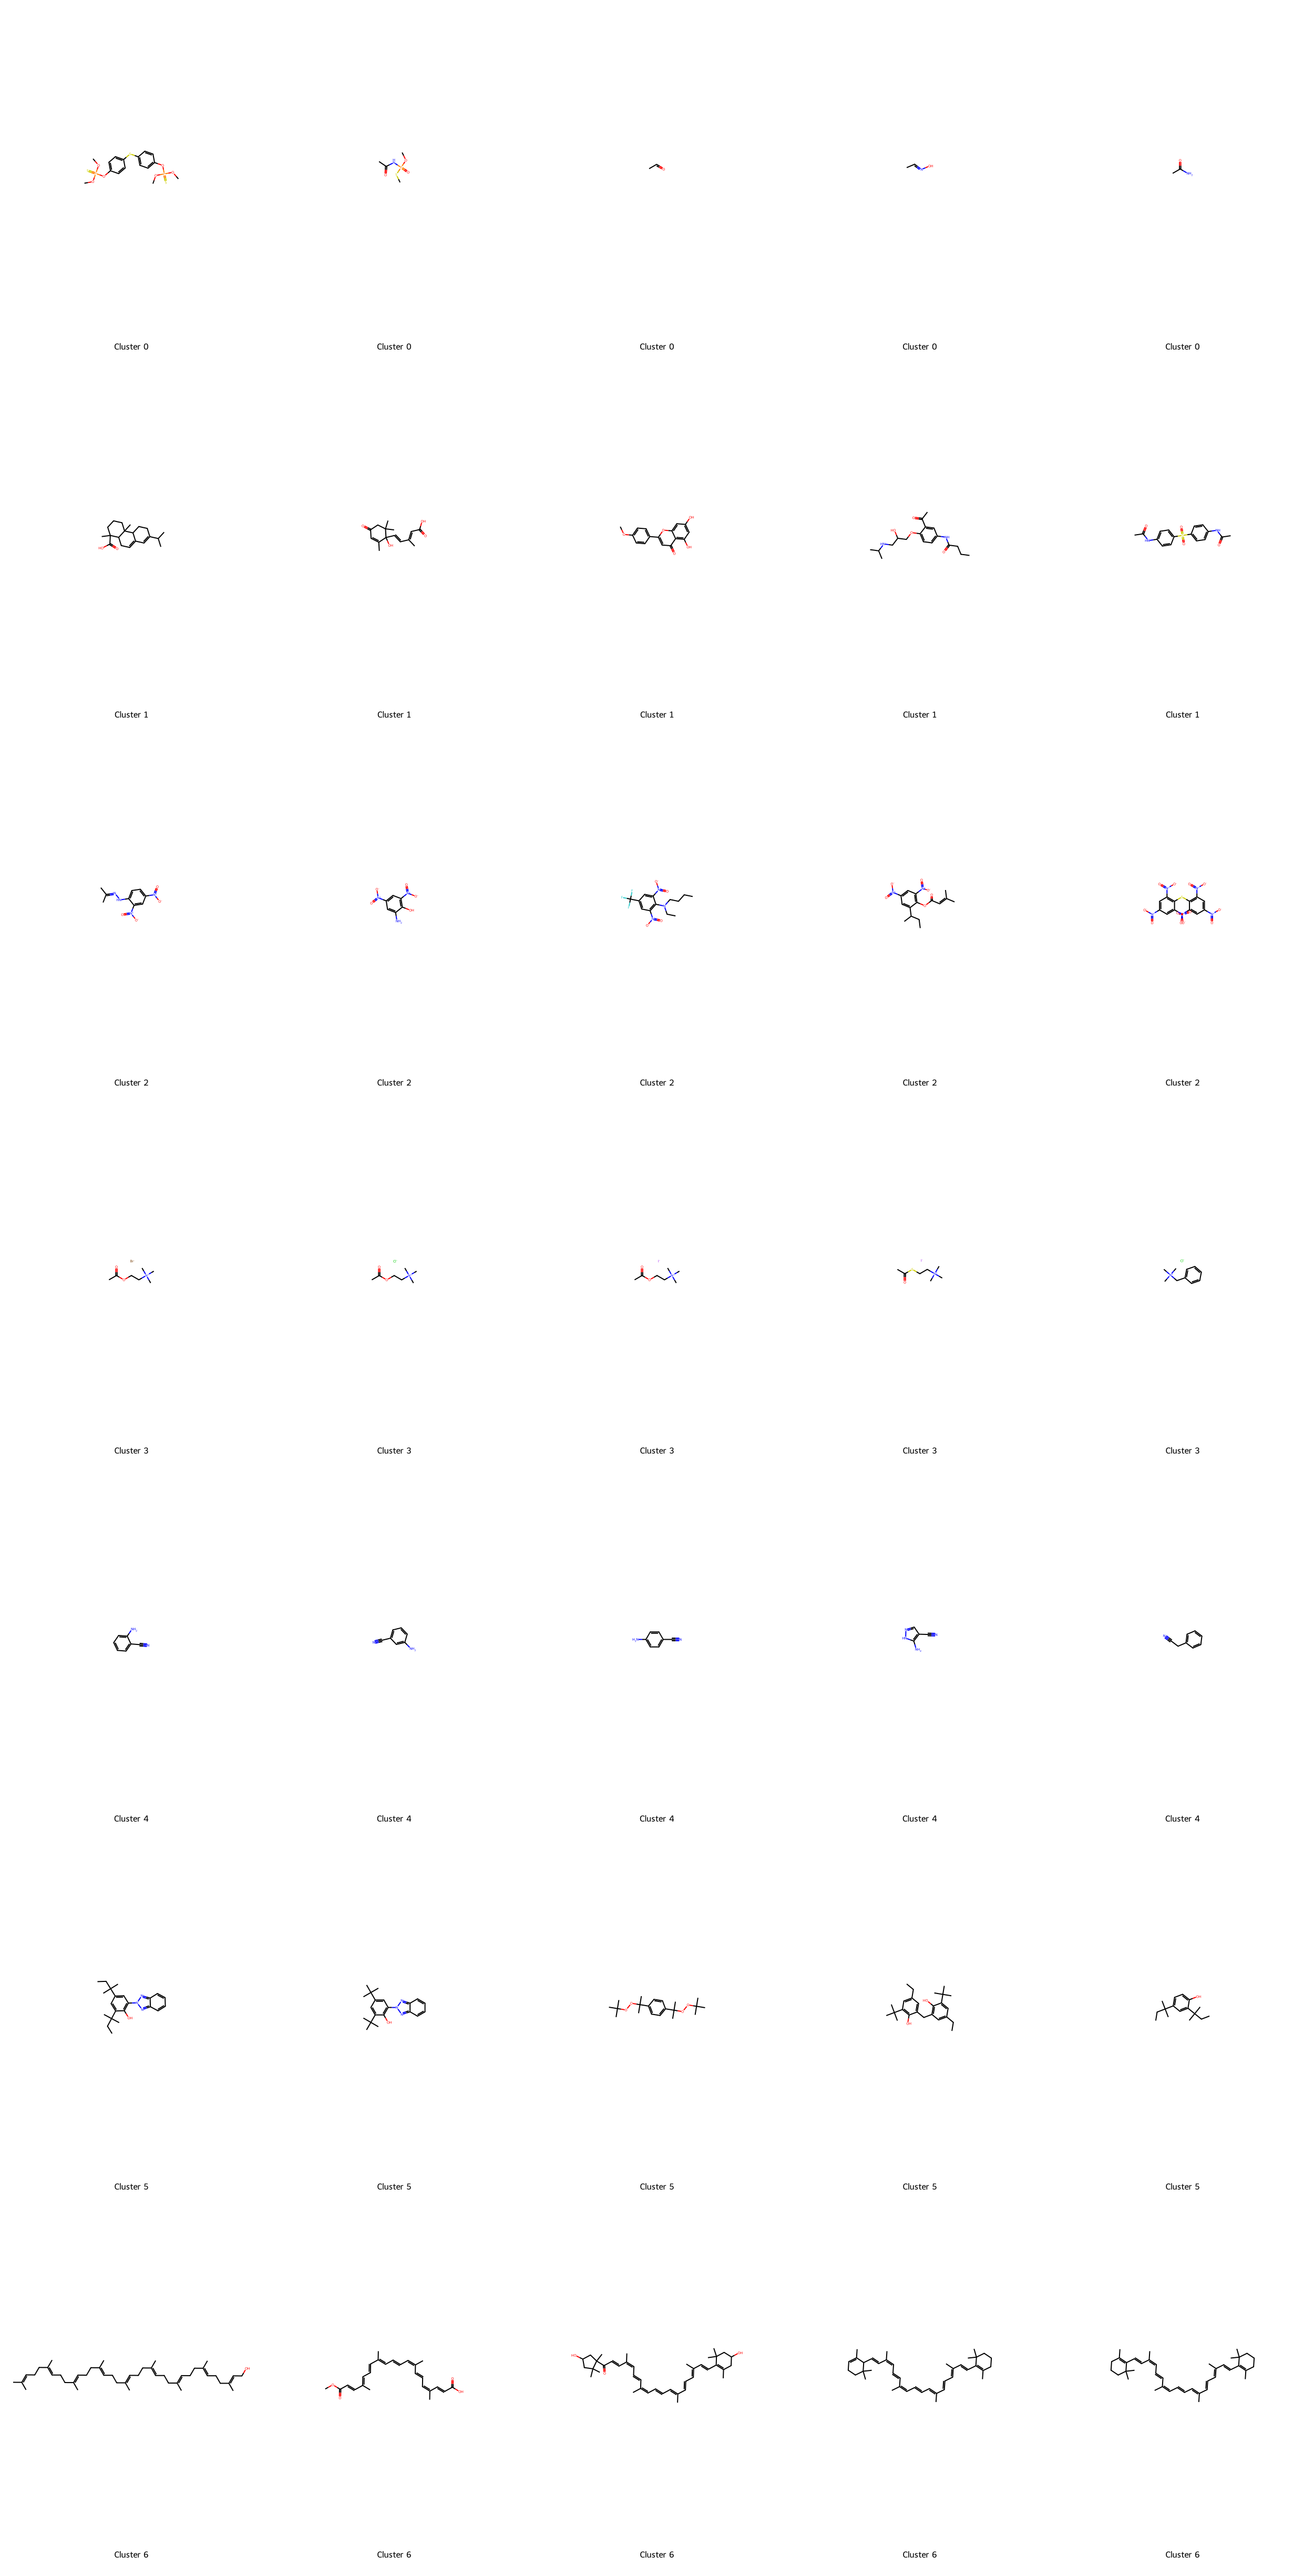

In [206]:
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import Image

# Assuming you have the 'umap_df' DataFrame loaded

def get_cluster_molecules(df, cluster_id, num_molecules=5):
    """
    Retrieves a specified number of molecules from a cluster.

    Args:
        df: DataFrame with 'Cluster' and 'SMILES' columns.
        cluster_id: ID of the cluster.
        num_molecules: Number of molecules to retrieve.

    Returns:
        A list of RDKit Mol objects.
    """
    smiles_list = df[df["Cluster"] == cluster_id]["SMILES"].tolist()
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    return [mol for mol in mols if mol is not None][:num_molecules]

# Get unique cluster IDs
cluster_ids = sorted(umap_df["Cluster"].unique())
print(cluster_ids)
# Create a list to store the molecules for the figure
mols_to_draw = []
legends = []
for cluster_id in cluster_ids:
    if cluster_id == -1:
        continue
    mols_to_draw.extend(get_cluster_molecules(umap_df, cluster_id))
    legends.extend([f"Cluster {cluster_id}"] * 5)
    # legends.extend([f"Cluster {cluster_id}"])

# Draw the molecules in a grid
grid = MolsToGridImage(
    mols_to_draw,
    molsPerRow=5,
    legends=legends,
    subImgSize=(500, 700),
    # returnPNG=True,
)
display(grid)
with open('cluster_molecules.png', 'wb') as f:
    f.write(grid.data)

In [224]:
m0 = Chem.Draw.MolToImage(mols_to_draw[0], size=(500, 200))
m0.save('m0.png')

In [229]:
cluster_ids = sorted(umap_df["Cluster"].unique())
for cluster_id in cluster_ids:
    if cluster_id == -1:
        continue
    mols = get_cluster_molecules(umap_df, cluster_id)
    for i, mol in enumerate(mols):
        img = Chem.Draw.MolToImage(mol, size=(500, 200))
        img.save(f'./images/cluster_{cluster_id}_{i}_molecule.png')
        print(f'cluster_{cluster_id}_{i}_molecule.png saved')



cluster_0_0_molecule.png saved
cluster_0_1_molecule.png saved
cluster_0_2_molecule.png saved
cluster_0_3_molecule.png saved
cluster_0_4_molecule.png saved
cluster_1_0_molecule.png saved
cluster_1_1_molecule.png saved
cluster_1_2_molecule.png saved
cluster_1_3_molecule.png saved
cluster_1_4_molecule.png saved
cluster_2_0_molecule.png saved
cluster_2_1_molecule.png saved
cluster_2_2_molecule.png saved
cluster_2_3_molecule.png saved
cluster_2_4_molecule.png saved
cluster_3_0_molecule.png saved
cluster_3_1_molecule.png saved
cluster_3_2_molecule.png saved
cluster_3_3_molecule.png saved
cluster_3_4_molecule.png saved
cluster_4_0_molecule.png saved
cluster_4_1_molecule.png saved
cluster_4_2_molecule.png saved
cluster_4_3_molecule.png saved
cluster_4_4_molecule.png saved
cluster_5_0_molecule.png saved
cluster_5_1_molecule.png saved
cluster_5_2_molecule.png saved
cluster_5_3_molecule.png saved
cluster_5_4_molecule.png saved
cluster_6_0_molecule.png saved
cluster_6_1_molecule.png saved
cluster_

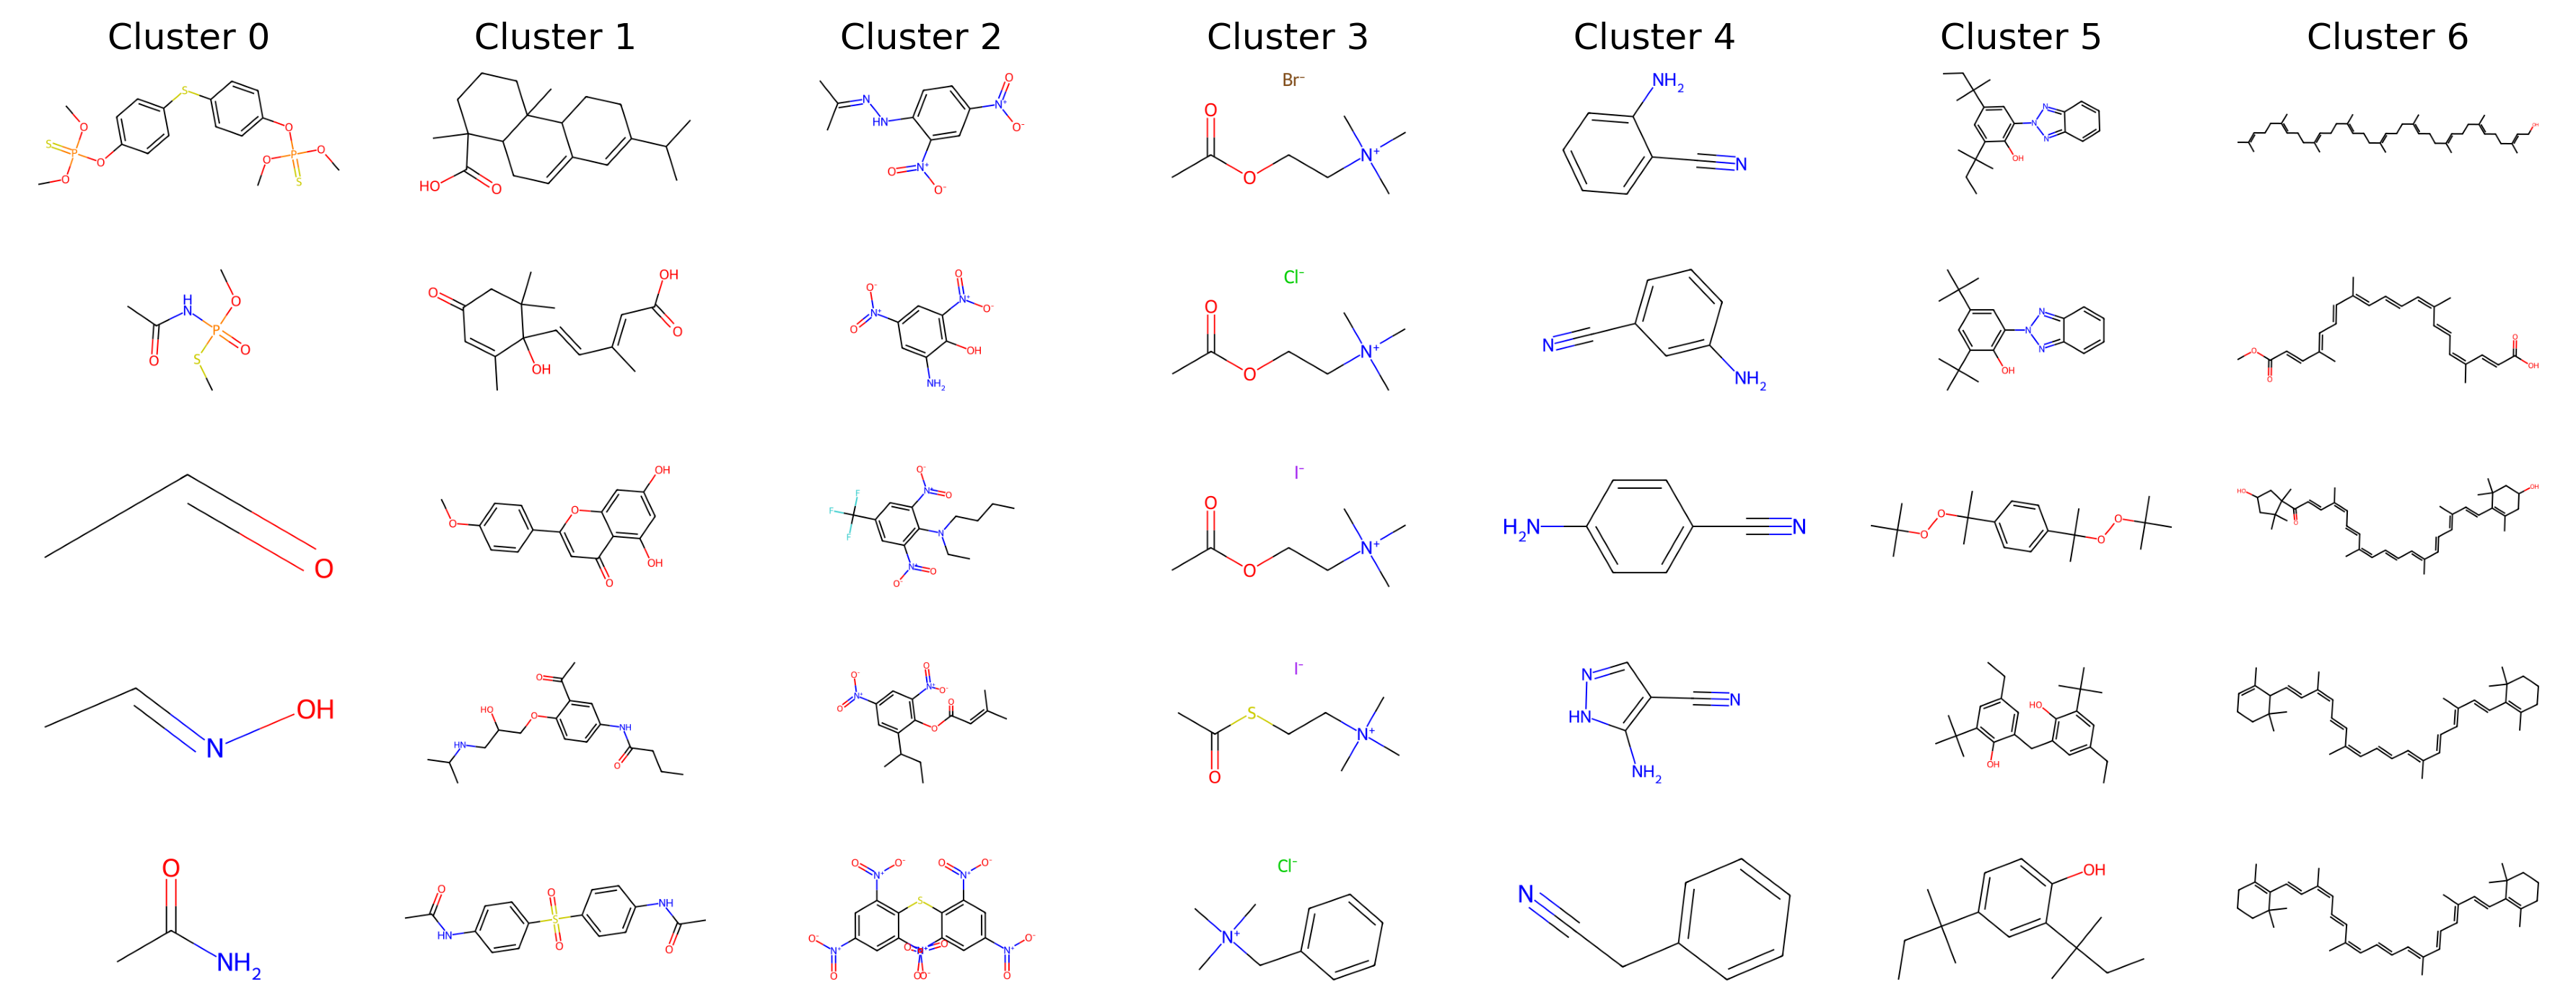

In [241]:
from PIL import Image
img = Chem.Draw.MolToImage(mols_to_draw[0][0], size=(500, 200))
# Convert PIL image to numpy array for matplotlib
img_array = np.array(img)
# img_array